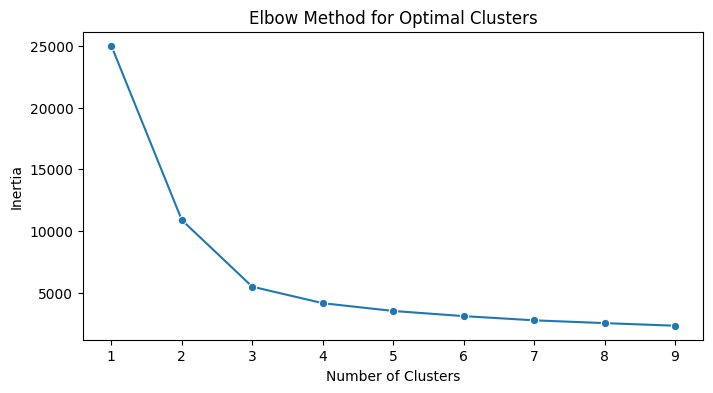

   CustomerID  total_spent  num_transactions  avg_transaction  total_balance  \
0           1     15460.65               4.0      3865.162500       101852.0   
1           2      8824.33               1.0      8824.330000        20529.0   
2           3     49823.80              10.0      4982.380000       812076.0   
3           4     23362.89               3.0      7787.630000       157788.0   
4           5     48589.89              15.0      3239.326000       342252.0   
5           6         0.00               0.0         0.000000            0.0   
6           7         0.00               0.0         0.000000            0.0   
7           8     24355.08               6.0      4059.180000       401680.0   
8           9     18077.93               3.0      6025.976667        33252.0   
9          10     44368.90               6.0      7394.816667        61530.0   

   num_accounts  Cluster  
0           1.0        1  
1           1.0        1  
2           2.0        2  
3          

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

excel_path = 'Banking_Analytics_Dataset.xlsx'
customers = pd.read_excel(excel_path, sheet_name='Customers')
accounts = pd.read_excel(excel_path, sheet_name='Accounts')
transactions = pd.read_excel(excel_path, sheet_name='Transactions')


account_txn = pd.merge(transactions, accounts, on='AccountID')


txn_agg = account_txn.groupby('CustomerID').agg(
    total_spent=('Amount', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction=('Amount', 'mean'),
    total_balance=('Balance', 'sum'),
    num_accounts=('AccountID', 'nunique')
).reset_index()


customer_features = pd.merge(customers[['CustomerID']], txn_agg, on='CustomerID', how='left')


customer_features.fillna(0, inplace=True)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))


inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))
sns.lineplot(x=K, y=inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)


print(customer_features.head(10))


customer_features.to_excel('Segmented_Customers.xlsx', index=False)


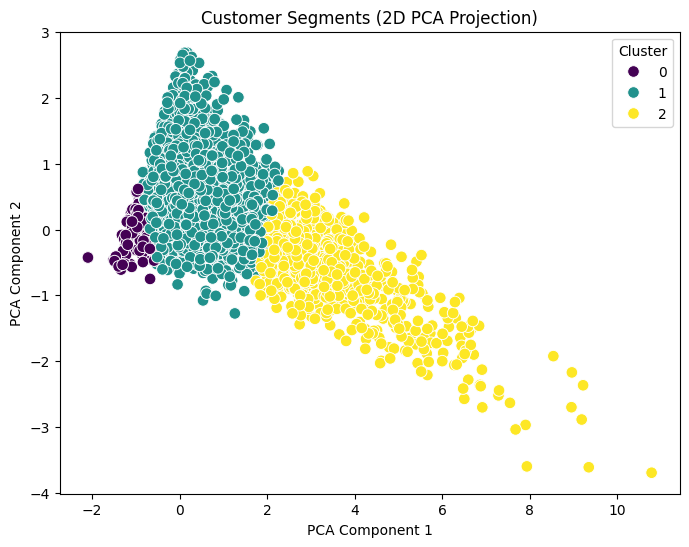

In [7]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)


customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=customer_features,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=70
)
plt.title('Customer Segments (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
